In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pandas import scatter_matrix
from collections import defaultdict
#from geopy.geocoders import Nominatim
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import src.airbnb_EDA_helper as eda
import src.airbnb_prediction_helper as pred

/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [169]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import statsmodels.api as sm
from scipy.misc import imread

#import gmplot

#import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)

## Load Data

In [5]:
monthly_data_raw_df = pd.read_excel('data/Loftium/Back testing - Copy.xlsx', sheetname='Monthly')
listing_data_raw_df = pd.read_excel('data/Loftium/Back testing - Copy.xlsx', sheetname='Listings')

In [6]:
monthly_data_raw_df.columns = monthly_data_raw_df.columns.str.replace(' ','_')
listing_data_raw_df.columns = listing_data_raw_df.columns.str.replace(' ','_').str.replace('\(','').str.replace('\)','').str.replace('-','')  

## Cleaning Data

In [20]:
listing_data_df = listing_data_raw_df.copy()

In [21]:
listing_data_df.Listing_Title = listing_data_raw_df.Listing_Title.str.lower()

In [22]:
listing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 46 columns):
Property_ID                      1936 non-null int64
Host_ID                          1935 non-null float64
Listing_Title                    1936 non-null object
Property_Type                    1936 non-null object
Listing_Type                     1936 non-null object
Created_Date                     1936 non-null datetime64[ns]
Last_Scraped_Date                1936 non-null datetime64[ns]
Country                          1936 non-null object
State                            1936 non-null object
City                             1936 non-null object
Neighborhood                     1727 non-null object
Metropolitan_Statistical_Area    1936 non-null object
Zipcode                          1936 non-null int64
Average_Daily_Rate               1936 non-null float64
Annual_Revenue_LTM               1936 non-null int64
Occupancy_Rate_LTM               1936 non-null float64
Occupancy_Cal

In [23]:
null_cols = eda.check_for_null(listing_data_df)

***WARNING*** : 1 null values in Host_ID
***WARNING*** : 209 null values in Neighborhood
***WARNING*** : 157 null values in Overall_Rating
***WARNING*** : 5 null values in Bathrooms
***WARNING*** : 4 null values in Calendar_Last_Updated
***WARNING*** : 299 null values in Response_Rate
***WARNING*** : 300 null values in Response_Time_min
***WARNING*** : 241 null values in Superhost
***WARNING*** : 1218 null values in Security_Deposit
***WARNING*** : 614 null values in Cleaning_Fee
***WARNING*** : 1062 null values in Extra_People_Fee
***WARNING*** : 3 null values in Published_Monthly_Rate
***WARNING*** : 4 null values in Published_Weekly_Rate
***WARNING*** : 650 null values in Checkin_Time
***WARNING*** : 636 null values in Checkout_Time


In [24]:
listing_data_df = eda.impute_null_columns(listing_data_df)

In [25]:
eda.check_for_null(listing_data_df)

[]

In [26]:
# Adding flags for views, water, priv bathrooms, parking
listing_data_df['view'] = listing_data_df.Listing_Title.str.contains(' view').astype(int)
water_pattern = r'(( water|^water|saltwater| lake|^lake|greenlake| bay|^bay).*(view))|(view).*( water|^water|saltwater| lake|^lake|greenlake| bay|^bay)'
listing_data_df['water'] = listing_data_df.Listing_Title.str.contains(water_pattern).astype(int)
listing_data_df['private_bath'] = listing_data_df.Listing_Title.str.contains('bath').astype(int)
listing_data_df['walk'] = (listing_data_df.Listing_Title.str.contains('walk')).astype(int)
listing_data_df['parking'] = (listing_data_df.Listing_Title.str.contains('parking')).astype(int)

# Adding flags for nonrooms
nonroom_pattern = r'((couch|futon|space))'
listing_data_df['nonroom'] = ((listing_data_df.Listing_Title.str.contains(nonroom_pattern)) & \
                          ~(listing_data_df.Listing_Title.str.contains('needle'))).astype(int)

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [27]:
# Converting Created_Date to Days_Since_Created
listing_data_df['Days_Since_Created'] = listing_data_df.Created_Date.apply(lambda x: (listing_data_df.Created_Date.max()-x).days)

In [28]:
listing_data_df['EDR'] = listing_data_df.Occupancy_Calculated * listing_data_df.Average_Daily_Rate

In [29]:
listing_data_df.shape

(1936, 54)

Let's remove any "non-relevant" data points

In [30]:
listing_data_df = listing_data_df[listing_data_df.Number_of_Bookings_LTM > 4]

In [38]:
listing_data_df = listing_data_df[listing_data_df.Occupancy_Calculated > .5]

In [39]:
listing_data_df.shape

(920, 54)

## EDA

In [19]:
# latitudes = listing_data_df.Latitude.values
# longitudes = listing_data_df.Longitude.values

In [20]:
# gmap = gmplot.GoogleMapPlotter(47.628, -122.35, 13)

In [21]:
# #gmap.scatter(latitudes, longitudes, 'cornflowerblue', edge_width=10)
# gmap.heatmap(latitudes, longitudes)
# gmap.draw("mymap.html")

In [22]:
# !pwd

`file://Users/johnkim/Google_Drive/Galvanize/Capstone/Airbnb/mymap.html`

In [40]:
listing_data_df.Property_Type.unique()

array([u'Apartment', u'Loft', u'House', u'Bed & Breakfast', u'Other',
       u'Condominium', u'Townhouse', u'Bungalow', u'Cabin', u'Camper/RV',
       u'Entire Floor', u'Bed &amp; Breakfast'], dtype=object)

In [41]:
listing_data_df['Property_Type'].replace('Bed &amp; Breakfast', 'Bed & Breakfast', inplace=True)

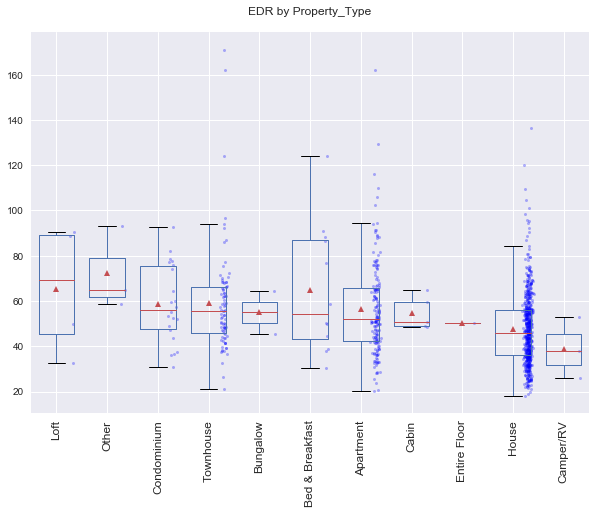

In [45]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Property_Type',column='EDR', 
                       rot=90, fontsize=12, figsize=(10,7), jitter_offset=0.3)
plt.show()

**Takeaways:**
- Townhouses command higher EDRs than houses, possibly due to their proximity to areas of interest, such as city centers, tourist attractions, etc In contrast, houses are locationed in suburban areas. 
- **Property type is likely correlated with location. Including in a linear model may lead to collinearity issues.**

In [46]:
listing_data_df.Property_Type.value_counts()

House              610
Apartment          172
Townhouse           86
Condominium         22
Bed & Breakfast     12
Cabin                5
Loft                 4
Camper/RV            3
Other                3
Bungalow             2
Entire Floor         1
Name: Property_Type, dtype: int64

In [47]:
# Only keeping relevant property types
features_Property_type_keep = ['House', 'Apartment','Townhouse','Condominium', 'Bed & Breakfast','Loft','Other']
listing_data_df = listing_data_df[listing_data_df.Property_Type.isin(features_Property_type_keep)]

In [48]:
listing_data_df.shape

(909, 54)

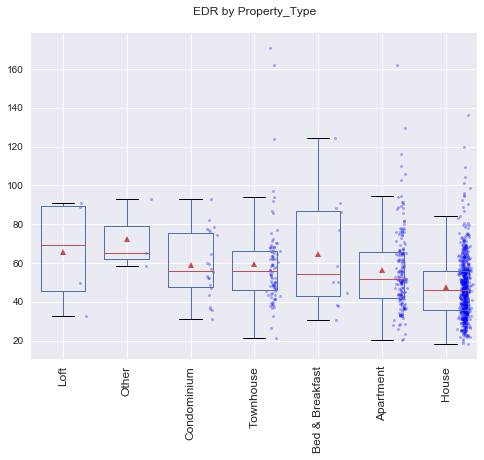

In [105]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Property_Type',column='EDR', 
                       rot=90, fontsize=12, figsize=(8,6), jitter_offset=0.3, show_outliers=True)

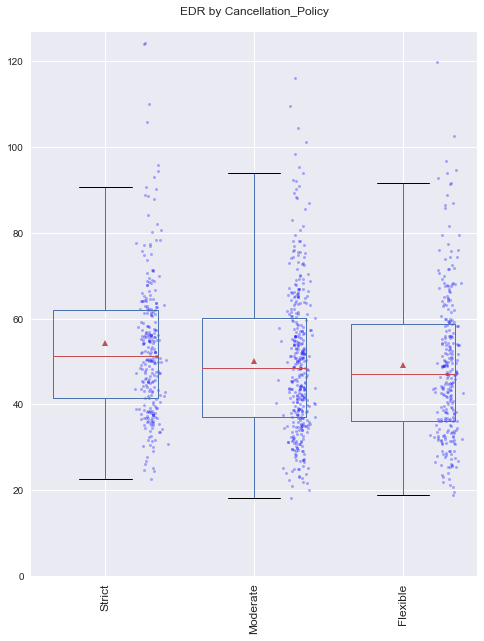

In [108]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Cancellation_Policy',column='EDR', 
                       rot=90, fontsize=12, figsize=(8,10), jitter_offset=0.3, show_outliers=False)

In [50]:
listing_data_df.Zipcode.unique()

array([98101, 98144, 98109, 98104, 98122, 98112, 98102, 98103, 98117,
       98105, 98107, 98116, 98108, 98119, 98115, 98146, 98118, 98136,
       98199, 98188, 98178, 98126, 98106, 98177, 98125, 98121, 98198,
       98155, 98168, 98166, 98133, 98148, 98134])

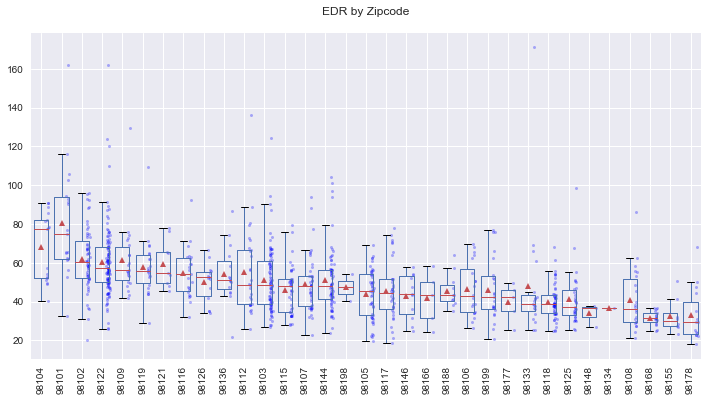

In [51]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Zipcode', column='EDR', 
                       rot=90, fontsize=10, jitter_offset=0.3, show_outliers=True)
plt.show()

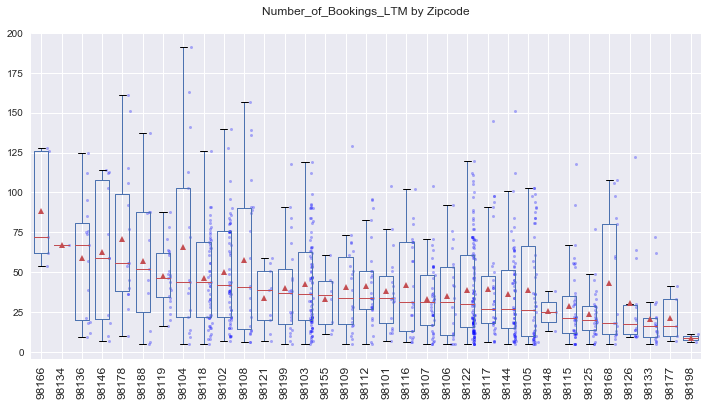

In [52]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Zipcode', column='Number_of_Bookings_LTM', 
                       rot=90, fontsize=12, jitter_offset=0.3, show_outliers=True)
plt.show()

**Takeaways:**
- Some variation is explained by zipcode
- However, suprising amount of variation per zipcode

In [53]:
temp_df = listing_data_df.groupby('Neighborhood').count()['Property_ID'].sort_values(ascending=False)

In [54]:
temp_df = temp_df[temp_df > 10]

In [55]:
temp_df = listing_data_df[listing_data_df.Neighborhood.isin(temp_df.index)]

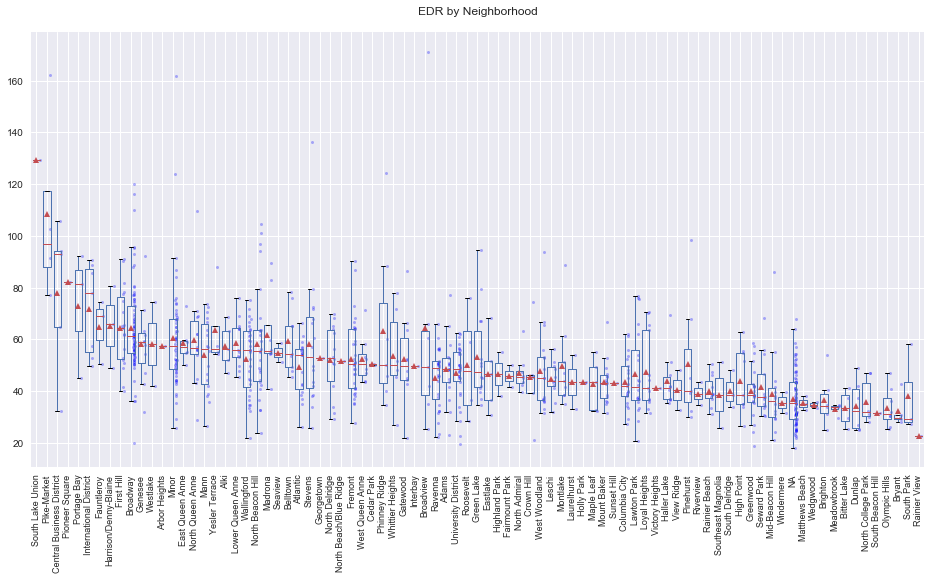

In [59]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Neighborhood', column='EDR', 
                       rot=90, fontsize=9, jitter_offset=0.3, figsize=(16,8), show_outliers=True)
plt.show()

In [60]:
listing_data_df[listing_data_df.Neighborhood=='Pike-Market']

,Property_ID,Host_ID,Listing_Title,Property_Type,Listing_Type,Created_Date,Last_Scraped_Date,Country,State,City,Neighborhood,Metropolitan_Statistical_Area,Zipcode,Average_Daily_Rate,Annual_Revenue_LTM,Occupancy_Rate_LTM,Occupancy_Calculated,Number_of_Bookings_LTM,Number_of_Reviews,Overall_Rating,Bedrooms,Bathrooms,Max_Guests,Calendar_Last_Updated,Response_Rate,Response_Time_min,Superhost,Cancellation_Policy,Security_Deposit,Cleaning_Fee,Extra_People_Fee,Published_Nightly_Rate,Published_Monthly_Rate,Published_Weekly_Rate,Checkin_Time,Checkout_Time,Minimum_Stay,Count_Reservation_Days_LTM,Count_Available_Days_LTM,Count_Blocked_Days_LTM,Number_of_Photos,Instantbook_Enabled,Listing_URL,Listing_Main_Image_URL,Latitude,Longitude,view,water,private_bath,walk,parking,nonroom,Days_Since_Created,EDR
0,7451624,8.55463e+06,private room in luxury dt tower,Apartment,Private room,2015-07-18,2016-02-07,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,245.97,35174,0.659,0.658986,53,33,5.0,1,1.0,2,2016-02-01,92.000000,0.050000,0.0,Strict,0.0,25.0,0.0,168,4704.0,1176.0,16:00:00,11:00:00,1,143,74,149,37,1,https://www.airbnb.com/rooms/7451624,https://a0.muscache.com/im/pictures/105611228/...,47.608447,-122.341485,0,0,0,0,0,0,390,162.090829
20,5415077,2.65472e+07,spacious room in pike place market!,Condominium,Private room,2015-02-19,2016-10-05,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,143.04,25890,0.539,0.538690,51,62,4.8,1,2.0,2,2016-09-14,92.000000,466.180000,1.0,Strict,0.0,30.0,0.0,160,3640.0,910.0,Anytime after 3PM,11:00:00,2,181,155,30,16,0,https://www.airbnb.com/rooms/5415077,https://a1.muscache.com/im/pictures/69722130/8...,47.609798,-122.340368,0,0,0,0,0,0,539,77.054286
202,11938847,2.3467e+07,super rad pad!,Apartment,Private room,2016-03-18,2016-10-04,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,126.23,15653,0.867,0.725146,44,27,4.9,1,1.0,2,2016-10-04,100.000000,164.320000,0.0,Flexible,0.0,0.0,20.0,100,2800.0,700.0,NA,NA,2,124,47,13,4,0,https://www.airbnb.com/rooms/11938847,https://a2.muscache.com/im/pictures/900481ae-f...,47.609447,-122.341567,0,0,0,0,0,0,146,91.535205
1415,14204510,3.89421e+07,private room at waterfront,Apartment,Private room,2016-07-26,2016-10-05,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,138.82,2360,0.850,0.739130,7,3,4.7,1,1.0,2,2016-09-26,95.585828,168.180165,0.0,Flexible,150.0,40.0,0.0,190,4200.0,1050.0,8AM - 11PM,18:00:00,1,17,6,39,8,0,https://www.airbnb.com/rooms/14204510,https://a2.muscache.com/im/pictures/a88dbbbb-7...,47.609689,-122.345059,0,0,0,0,0,0,16,102.606087


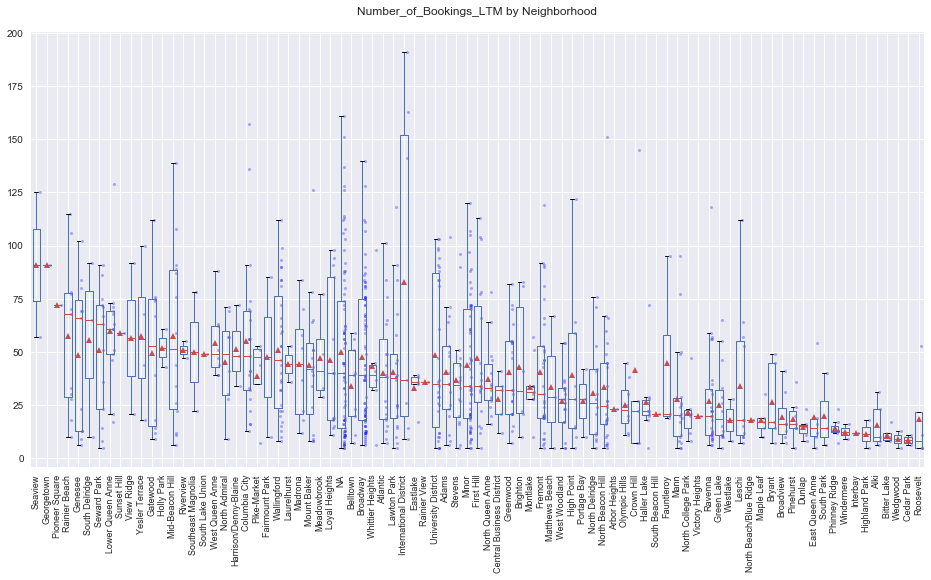

In [61]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Neighborhood', column='Number_of_Bookings_LTM', 
                       rot=90, fontsize=9, jitter_offset=0.3, figsize=(16,8), show_outliers=True)
plt.show()

**Takeaways:**
- As one would expect, properties in the Pike-Market neighborhood command higher EDRs, but the sample is small. 
- There is still a surprising amount of variation in EDR per neighborhood. 

In [62]:
# Given Pike-Market's clear impact on EDR, include as a flag
listing_data_df['Pike_Market'] = (listing_data_df.Neighborhood=='Pike-Market').astype(int)

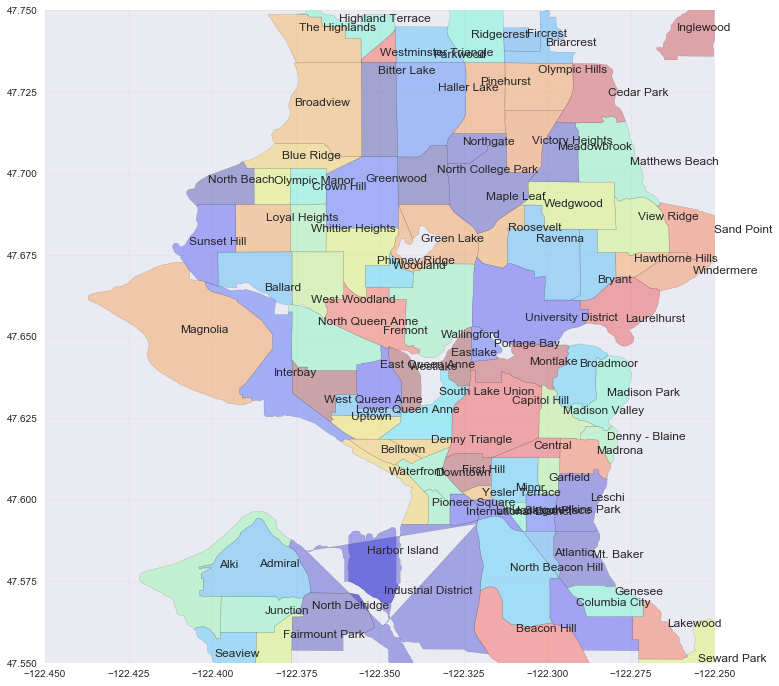

In [63]:
shapesfile = 'data/Zillow/ZillowNeighborhoods-WA/ZillowNeighborhoods-WA.shp'
eda.plot_neighborhoods(-122.45, -122.25, 47.55, 47.75, shapesfile, figsize=(12,12))

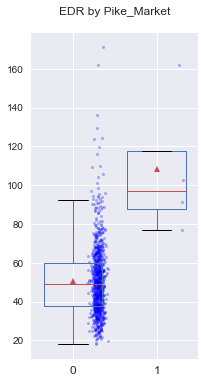

In [64]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Pike_Market', column='EDR', 
                        sort_flag=False,
                        rot=0, figsize=(3,6), fontsize=12, jitter_offset=0.3, show_outliers=True)

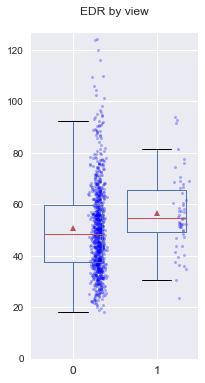

In [65]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='view', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

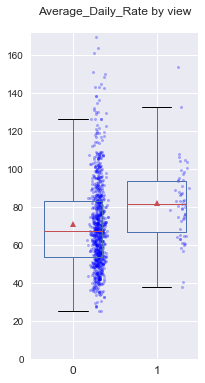

In [66]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='view', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

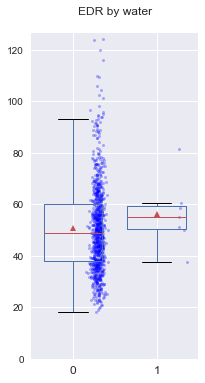

In [67]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='water', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a "water view" have **surprisingly** lower EDR

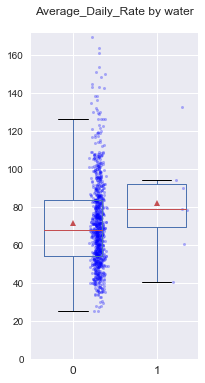

In [68]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='water', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a "view" have higher median and average ADRs

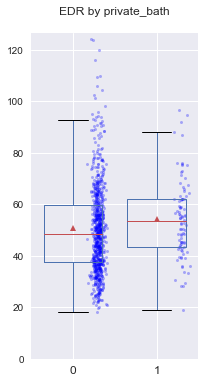

In [69]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='private_bath', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a private bathrooms have higher median and average EDRs

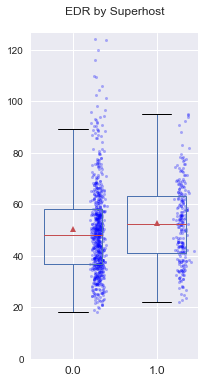

In [70]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Superhost', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with Superhosts have higher median and average EDRs

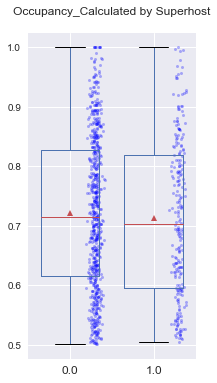

In [71]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Superhost', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=True)
plt.show()

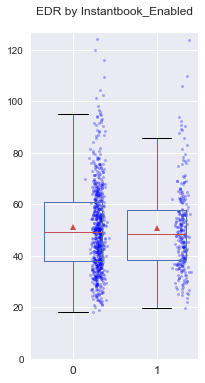

In [72]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Instantbook_Enabled', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

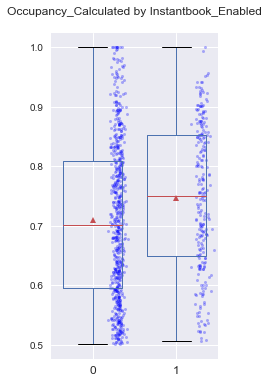

In [73]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Instantbook_Enabled', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=True)

**Takeaways:**
- Properties with Instabook_Enabled have higher median and average EDRs

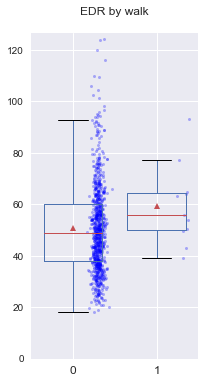

In [74]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

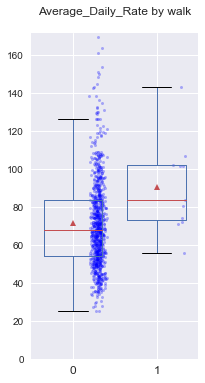

In [75]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

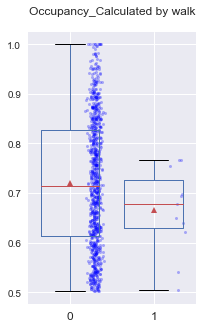

In [76]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,5), jitter_offset=0.3, show_outliers=True)

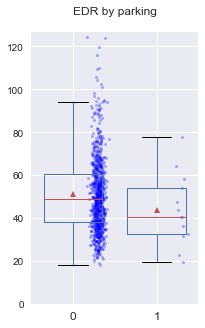

In [78]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='parking', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,5), jitter_offset=0.3, show_outliers=False)

(0, 200)

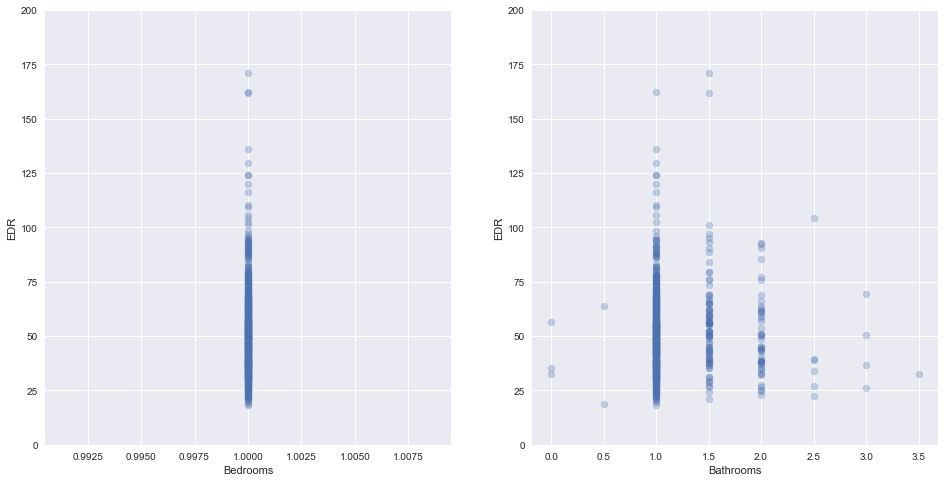

In [93]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Bedrooms'], listing_data_df['EDR'], alpha=0.3)
ax[0].set_xlabel('Bedrooms')
ax[0].set_ylabel('EDR')
ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Bathrooms'], listing_data_df['EDR'], alpha=0.3)
ax[1].set_xlabel('Bathrooms')
ax[1].set_ylabel('EDR')
#ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(0,200)

### How do User Reviews affect EDR?

(0, 200)

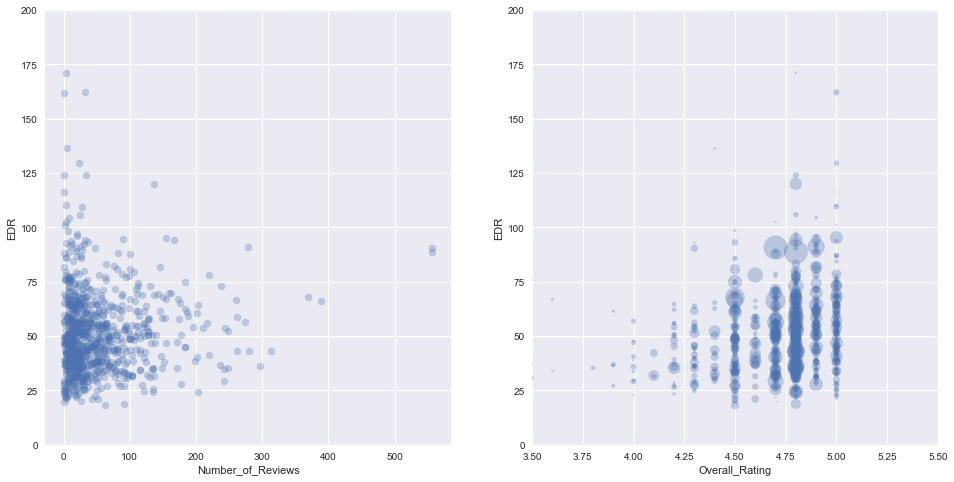

In [79]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Number_of_Reviews'], listing_data_df['EDR'], alpha=0.3)
ax[0].set_xlabel('Number_of_Reviews')
ax[0].set_ylabel('EDR')
ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Overall_Rating'], listing_data_df['EDR'], 
              alpha=0.3, s=listing_data_df['Number_of_Reviews'])
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('EDR')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(0,200)

There are long tails on both x and y axes, so let's try a log transform.

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


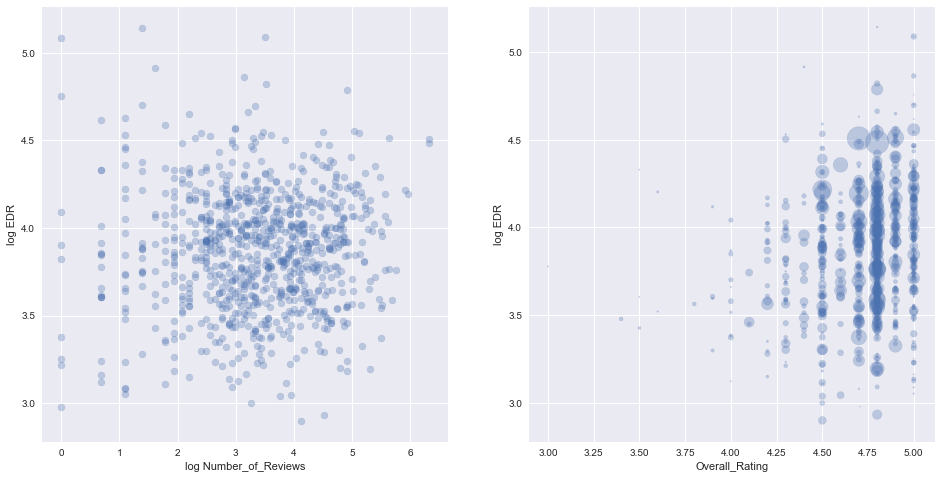

In [80]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(np.log(listing_data_df['Number_of_Reviews']), np.log(listing_data_df['EDR']), alpha=0.3)
ax[0].set_xlabel('log Number_of_Reviews')
ax[0].set_ylabel('log EDR')
# ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Overall_Rating'], np.log(listing_data_df['EDR']), 
              alpha=0.3, s=listing_data_df['Number_of_Reviews'])
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('log EDR')
# ax[1].set_xlim(3.5,5.5)
# ax[1].set_ylim(0,200)

**Takeaways:**
- As expected, as Number_of_Reviews increases, the EDR tends to increase
- As expected, as Overall_Rating increases, the EDR tends to increase

(3.2, 5.2)

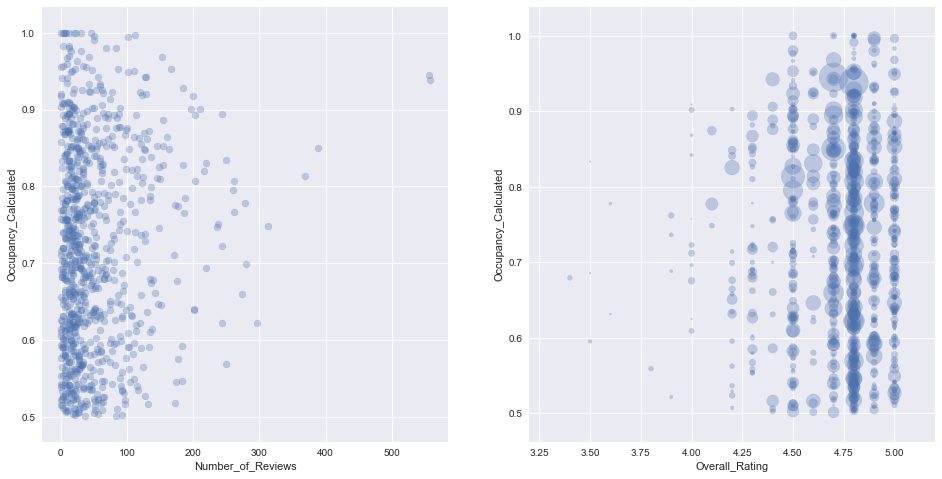

In [81]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Number_of_Reviews'], listing_data_df['Occupancy_Calculated'], 
              alpha=0.3)
ax[0].set_xlabel('Number_of_Reviews')
ax[0].set_ylabel('Occupancy_Calculated')
ax[1].scatter(listing_data_df['Overall_Rating'], listing_data_df['Occupancy_Calculated'],
              alpha=0.3, s=listing_data_df['Number_of_Reviews']*1.5)
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('Occupancy_Calculated')
ax[1].set_xlim(3.2,5.2)


**Takeaways:**
- As expected, as Number_of_Reviews increases, the Occupancy Rate tends to increase
- As expected, as Overall_Rating increases, the Occupancy Rate tends to increase

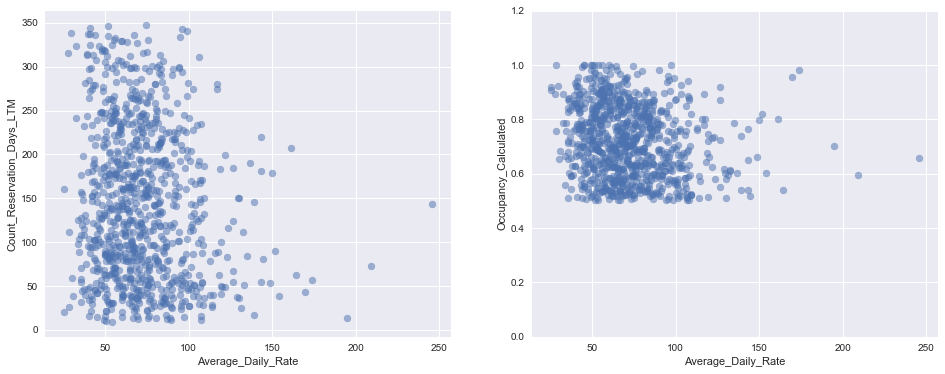

In [82]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Average_Daily_Rate'], listing_data_df['Count_Reservation_Days_LTM'], alpha=0.5)
ax[0].set_xlabel('Average_Daily_Rate')
ax[0].set_ylabel('Count_Reservation_Days_LTM')
ax[1].scatter(listing_data_df['Average_Daily_Rate'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[1].set_xlabel('Average_Daily_Rate')
ax[1].set_ylabel('Occupancy_Calculated')
ax[1].set_ylim(0,1.2)
plt.show()

**Takeaways:**
- As expected, negative correlation between ADR and Count_Reservation_Days_LTM
- As expected, negative correlation between ADR and Occupancy_calculated

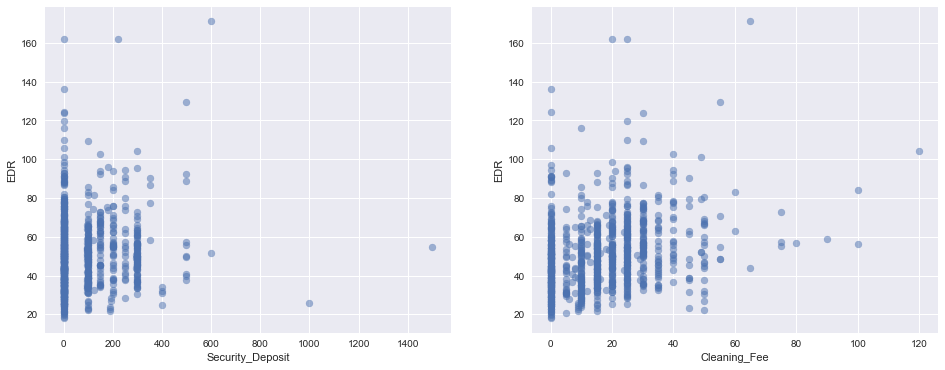

In [212]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Security_Deposit'], listing_data_df['EDR'], alpha=0.5)
ax[0].set_xlabel('Security_Deposit')
ax[0].set_ylabel('EDR')
ax[1].scatter(listing_data_df['Cleaning_Fee'], listing_data_df['EDR'], alpha=0.5)
ax[1].set_xlabel('Cleaning_Fee')
ax[1].set_ylabel('EDR')
#ax[1].set_ylim(0,1.2)
plt.show()

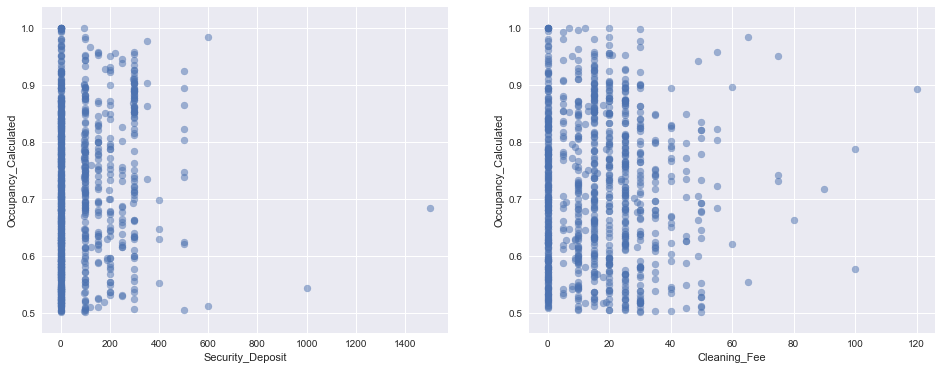

In [83]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Security_Deposit'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[0].set_xlabel('Security_Deposit')
ax[0].set_ylabel('Occupancy_Calculated')
ax[1].scatter(listing_data_df['Cleaning_Fee'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[1].set_xlabel('Cleaning_Fee')
ax[1].set_ylabel('Occupancy_Calculated')
#ax[1].set_ylim(0,1.2)
plt.show()

**Takeaways:**
- Occupancy_calculated largely independent of Security_Deposit and Cleaning_Fee

# Predictive Modeling (Annual)

In [84]:
listing_data_df.shape

(909, 55)

In [85]:
listing_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Listing_Title',                 u'Property_Type',
                        u'Listing_Type',                  u'Created_Date',
                   u'Last_Scraped_Date',                       u'Country',
                               u'State',                          u'City',
                        u'Neighborhood', u'Metropolitan_Statistical_Area',
                             u'Zipcode',            u'Average_Daily_Rate',
                  u'Annual_Revenue_LTM',            u'Occupancy_Rate_LTM',
                u'Occupancy_Calculated',        u'Number_of_Bookings_LTM',
                   u'Number_of_Reviews',                u'Overall_Rating',
                            u'Bedrooms',                     u'Bathrooms',
                          u'Max_Guests',         u'Calendar_Last_Updated',
                       u'Response_Rate',             u'Response_Time_min',
                         

In [213]:
listing_gdbr_cols_keep = [
# ==== LISTING DETAILS ==========
#'Bathrooms', 'Bedrooms',
'Days_Since_Created', 'Number_of_Photos','Instantbook_Enabled',
# ---- Exclude 
#'Property_ID', 'Listing_Title', 'Listing_Main_Image_URL','Listing_URL','Created_Date', 
#'Check-in_Time', 'Checkout_Time', 'Max_Guests', 'Minimum_Stay', 
    
# ==== BOOKING HISTORY =========
'EDR', 
# ---- Exclude 
#'Occupancy_Calculated', 'Annual_Revenue_LTM', 'Average_Daily_Rate' 'Last_Scraped_Date','Calendar_Last_Updated', 
#'Number_of_Bookings_LTM','Count_Blocked_Days_LTM', 'Count_Reservation_Days_LTM','Count_Available_Days_LTM',

# ==== LOCATION ================
'Latitude', 'Longitude',
# ---- Exclude 
#'Country', 'State','City', 'Metropolitan_Statistical_Area',    

# ==== EXTENDED STAY DETAILS ===
# --- -Exclude 
#'Published_Monthly_Rate','Published_Nightly_Rate', 'Published_Weekly_Rate', 
 
# ==== ADDITIONAL FEES =========
'Security_Deposit', 'Extra_People_Fee', 'Cleaning_Fee', 

# ==== HOST QUALITY ============
'Superhost', 'Overall_Rating','Number_of_Reviews',  
# ---- Exclude 
#'Response_Rate', 'Response_Time_min',

# ==== SPECIAL FEATURES ========
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water','parking',
# ---- Exclude 
#'walk',
]

listing_gdbr_cols_dummy = [
#'Neighborhood',
#'Zipcode',
'Cancellation_Policy',    
'Property_Type'    
]

In [214]:
gdbr_pred_df, gdbr_train_df, gdbr_model = pred.get_model_predictions_df(GradientBoostingRegressor, 
                                                                     listing_data_df, 'EDR', 
                                                                     listing_gdbr_cols_keep, listing_gdbr_cols_dummy,
                                                                     loft_sample=False)

Running <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> for label EDR
Splitting into 681 training instances
((681, 27), (228, 27))
Running cross validation...
CV MSE: 244.488980777, CV R2: 0.275259717367
Training model...
Test MSE: 244.234345348, Test R2: 0.321321885014
Returned pred df with shape (228,)


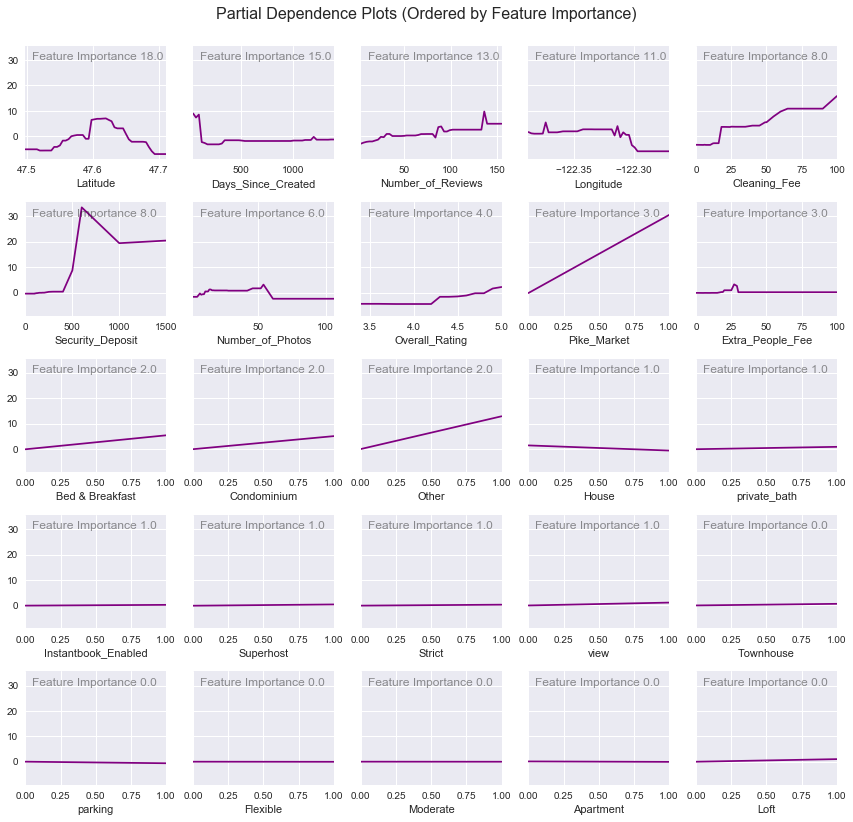

In [242]:
pred.plot_partial_dependency_plots(gdbr_model,gdbr_train_df, 30)

In [246]:
gdbr_pred_X_df = pred.prep_model_df(listing_data_df, listing_gdbr_cols_keep, pred.get_dummy_dfs(listing_data_df, listing_gdbr_cols_dummy))

In [264]:
# Tuning by cross validation
N_ESTIMATORS = 4000
N_FOLDS = 10
X = gdbr_pred_X_df.drop('EDR', axis=1)
y = gdbr_pred_X_df['EDR']

train_scores = np.zeros((N_FOLDS, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_ESTIMATORS))

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(kf.split(X)):
    #print train_idxs
    X_train, y_train = X.iloc[train_idxs], y.iloc[train_idxs]
    X_test, y_test = X.iloc[test_idxs], y.iloc[test_idxs]
    model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
    model.fit(X_train, y_train)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_scores[k, i] = model.loss_(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_scores[k, i] = model.loss_(y_test, y_pred)
        
mean_train_score = np.mean(train_scores, axis=0)
mean_test_score = np.mean(test_scores, axis=0)

optimal_n_trees = np.argmin(mean_test_score)
optimal_score = mean_test_score[optimal_n_trees]
optimal_point = (optimal_n_trees, optimal_score)

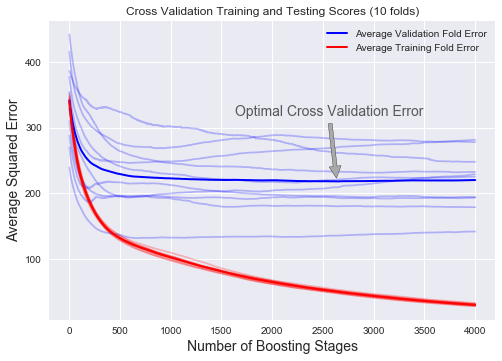

In [282]:
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, train_scores[i, :], color='red', alpha=0.25)
    
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, test_scores[i, :], color='blue', alpha=0.25)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_score, color='blue', linewidth=2,
         label='Average Validation Fold Error')
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_score, color='red', linewidth=2,
         label='Average Training Fold Error')

plt.annotate('Optimal Cross Validation Error', optimal_point,
              xytext=(optimal_point[0] - 1000, optimal_point[1] + 100),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )
plt.title("Cross Validation Training and Testing Scores (10 folds)")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")


In [112]:
gdbr_pred_df.to_csv('data/gdbr_pred_results_OR50_annual.csv', sep=',', encoding='utf-8')

In [113]:
train_ind, test_ind = pred.get_loftium_train_test_split(listing_data_df)

(604, 305)


# Exploring the Monthly-level Data

In [314]:
monthly_data_df = monthly_data_raw_df.copy()

In [315]:
monthly_data_df.shape

(18595, 21)

In [316]:
#Only keeping properties with annual occupancy rates above 50%
prop_ids_to_keep = listing_data_df.Property_ID.unique()

In [317]:
monthly_data_df = monthly_data_df[monthly_data_df.Property_ID.isin(prop_ids_to_keep)]

In [318]:
monthly_data_df.shape

(9466, 21)

In [319]:
monthly_data_df['Property_Type'].replace('Bed &amp; Breakfast', 'Bed & Breakfast', inplace=True)
monthly_data_df['Month'] = monthly_data_df.Reporting_Month.apply(lambda x: x.month)
monthly_data_df['EDR'] = monthly_data_df.Occupancy_Rate * monthly_data_df.ADR

In [320]:
monthly_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR'],
      dtype='object')

In [321]:
monthly_data_df.sort_values(by='Reservation_Days', ascending=True)[[
       'Property_ID', 'Host_ID', 'Property_Type', 'Listing_Type', 'Bedrooms',
       'Occupancy_Rate', 'Revenue', 'ADR',
       'Number_of_Reservations', 'Reservation_Days', 'Available_Days',
       'Blocked_Days', 'Zip_code', 'Neighborhood',
       'Latitude', 'Longitude', 'Month',
       'EDR']].head(15)

,Property_ID,Host_ID,Property_Type,Listing_Type,Bedrooms,Occupancy_Rate,Revenue,ADR,Number_of_Reservations,Reservation_Days,Available_Days,Blocked_Days,Zip_code,Neighborhood,Latitude,Longitude,Month,EDR
13866,7724630,26877490.0,Apartment,Private room,1,1.000,70.00,70.00,1,1,0,30,98107,West Woodland,47.672717,-122.361417,7,70.00000
13333,7390195,38176125.0,Apartment,Private room,1,0.042,95.00,95.00,2,1,23,6,98199,Interbay,47.635773,-122.388619,9,3.99000
16534,10234558,31887689.0,Condominium,Private room,1,0.050,70.00,70.00,1,1,19,11,98107,Adams,47.670662,-122.378666,1,3.50000
2004,853112,4453873.0,House,Private room,1,1.000,110.00,110.00,2,1,0,30,98188,NaN,47.429987,-122.290957,8,110.00000
17957,13046519,8539387.0,Bed & Breakfast,Private room,1,0.045,81.17,81.17,1,1,21,9,98199,Lawton Park,47.649578,-122.393496,5,3.65265
2011,853112,4453873.0,House,Private room,1,1.000,85.00,85.00,1,1,0,30,98188,NaN,47.429987,-122.290957,7,85.00000
2023,853112,4453873.0,House,Private room,1,1.000,83.33,83.33,1,1,0,29,98188,NaN,47.429987,-122.290957,9,83.33000
16393,9878882,28011170.0,House,Private room,1,0.037,45.00,45.00,1,1,26,2,98125,Meadowbrook,47.712508,-122.294354,2,1.66500
2076,877203,287172.0,House,Private room,1,0.032,66.07,66.07,1,1,30,0,98144,Atlantic,47.600266,-122.299867,1,2.11424
16358,9823290,50596206.0,House,Private room,1,0.125,65.00,65.00,1,1,7,23,98144,Mount Baker,47.585650,-122.292887,3,8.12500


In [322]:
#Only keeping monthly data with reservation days > 10 days
monthly_data_df = monthly_data_df[monthly_data_df.Reservation_Days>10]

In [323]:
monthly_data_df.shape

(7418, 23)

### Let's see how prices vary by month (seasonality)

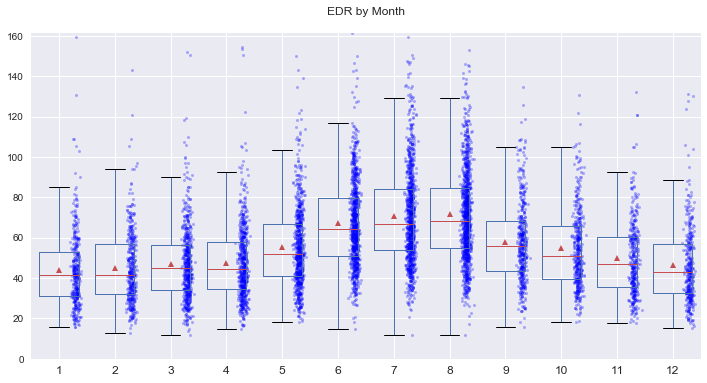

In [324]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='EDR', 
                       rot=0, fontsize=12, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=False)

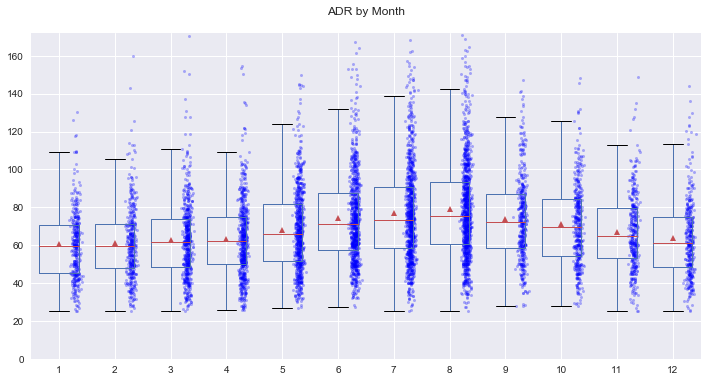

In [325]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='ADR', 
                       rot=0, fontsize=10, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=False)

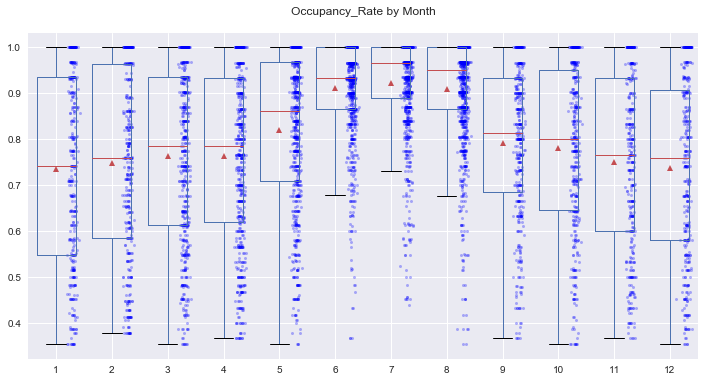

In [326]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='Occupancy_Rate', 
                       rot=0, fontsize=10, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=True)

**Takeaways:**
- ADRs and OccRate increase significantly during the summer periods
- **OccRate increases more than ADR during the summer**

### Which zipcodes exhibit the most seasonality?

In [327]:
monthly_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR'],
      dtype='object')

In [328]:
gb_month = monthly_data_df.groupby(['Zip_code','Month']).agg({'Occupancy_Rate': np.mean, 
                                                              'ADR':np.mean, 
                                                              'EDR':np.mean,
                                                              'Property_ID': len})

In [329]:
gb_monthly_var = gb_month['EDR'].reset_index().groupby('Zip_code').std()

top_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][:3]
bot_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][-3:]

top_and_bot_month_var = np.concatenate((np.array(top_month_var.index),
                                        np.array(bot_month_var.index)))

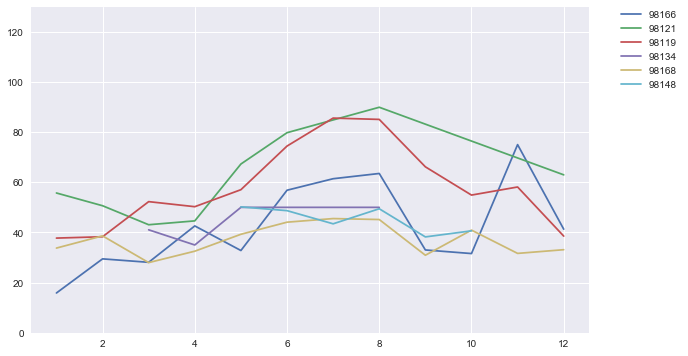

In [330]:
plt.figure(figsize=(10,6))

for item in top_and_bot_month_var:
    item_df = monthly_data_df[monthly_data_df.Zip_code==item]
    item_group_df = item_df.groupby('Month').mean()['EDR']
    
    plt.plot(item_group_df.index, item_group_df, label=item)

plt.ylim(0,130)
#plt.title('EDR by Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


**Takeaways**
- Top zipcodes exhibit significantly higher EDR during summer compared to bottom

In [331]:
gb_month = monthly_data_df.groupby(['Neighborhood','Month']).agg({'Occupancy_Rate': np.mean, 
                                                                  'ADR':np.mean, 
                                                                  'EDR':np.mean,
                                                                  'Property_ID': len
                                                                 })

In [332]:
gb_monthly_var = gb_month['EDR'].reset_index().groupby('Neighborhood').std()

top_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][:3]
bot_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][-3:]

top_and_bot_month_var = np.concatenate((np.array(top_month_var.index),
                                        np.array(bot_month_var.index)))

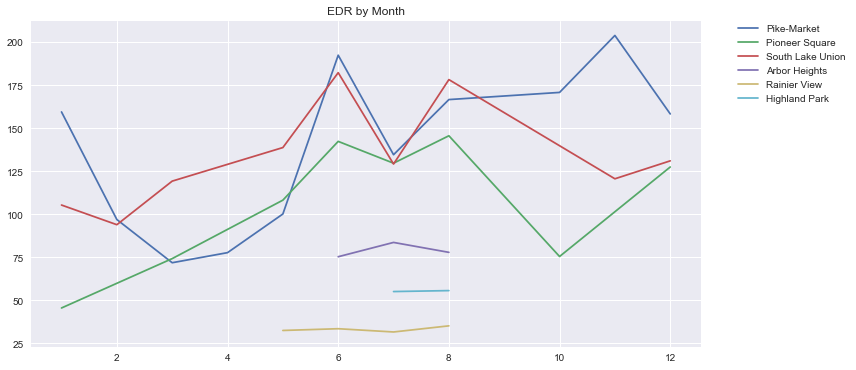

In [333]:
plt.figure(figsize=(12,6))

for item in top_and_bot_month_var:
    item_df = monthly_data_df[monthly_data_df.Neighborhood==item]
    item_group_df = item_df.groupby('Month').mean()['EDR']
    
    plt.plot(item_group_df.index, item_group_df, label=item)

plt.title('EDR by Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Analyzing Outliers

In [91]:
def remove_outliers(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    outlier_upper_limit = df[column].quantile(.75) + 1.5*(iqr)
    outlier_lower_limit = df[column].quantile(.25) - 1.5*(iqr)
    return df[(df[column] < outlier_upper_limit) & (df[column] > outlier_lower_limit)]

In [92]:
def get_outlier_ind(df, by):
    iqr = df[by].quantile(0.75) - df[by].quantile(0.25)
    outlier_upper_limit = df[by].quantile(.75) + 1.5*(iqr)
    outlier_lower_limit = df[by].quantile(.25) - 1.5*(iqr)
    #return df[(df[by] > outlier_upper_limit) | (df[by] < outlier_lower_limit)].index.values
    return df[(df[by] > outlier_upper_limit)].index.values

In [93]:
# Finding outliers per neighborhood
outliers_ind = []
for nhood in monthly_data_df.Neighborhood.unique():
    outliers_nhood_ind = get_outlier_ind(monthly_data_df[monthly_data_df.Neighborhood==nhood], 'EDR')
    #print (nhood, outliers_nhood_ind)
    for ind in outliers_nhood_ind:
        outliers_ind.append(ind)

In [94]:
monthly_data_outliers_df = monthly_data_df.loc[outliers_ind].sort_values('EDR', ascending=False)

# Predictive modeling (Monthly)

Let's reduce the features to only those that are relevant for predictive modeling, based on what we learned above.

## Gradient Boosting

We will be using gradient boosting due to the non-linear nature of key features, particularly latitude and longitude. 

Let's reduce features to only those relevant to a gradient boosting model.

In [334]:
monthly_gdbr_cols_keep = [
#'Property_ID',
#'Host_ID',
#'Listing_Type',
#'Bedrooms',
#'Reporting_Month',
#'Occupancy_Rate',
#'Revenue','ADR',
#'Number_of_Reservations','Reservation_Days','Available_Days','Blocked_Days',
#'Country','State','City','Metropolitan_Statistical_Area',
'Latitude','Longitude',
'EDR',
]

monthly_gdbr_cols_dummy =[
#'Zip_code',
#'Neighborhood',
'Month',
'Property_Type',
]

In [335]:
gdbr_monthly_pred_df, gdbr_monthly_train_df, gdbr_monthly_model = pred.get_model_predictions_df(GradientBoostingRegressor, 
                                                                     monthly_data_df, 'EDR', 
                                                                     monthly_gdbr_cols_keep, monthly_gdbr_cols_dummy,
                                                                     loft_sample=True)

Running <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> for label EDR
(4830, 2588)
Splitting into 4830 training instances
((4830, 21), (2588, 21))
Running cross validation...
CV MSE: 351.940139392, CV R2: 0.350340715047
Training model...
Test MSE: 412.469419858, Test R2: 0.337758982264
Returned pred df with shape (2588,)


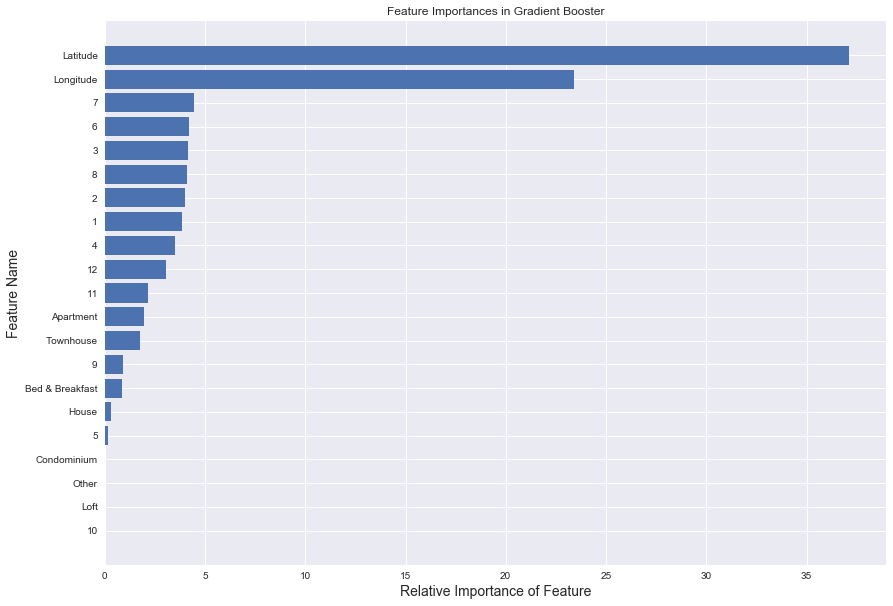

In [336]:
pred.plot_feature_importances(gdbr_monthly_model,gdbr_monthly_train_df)

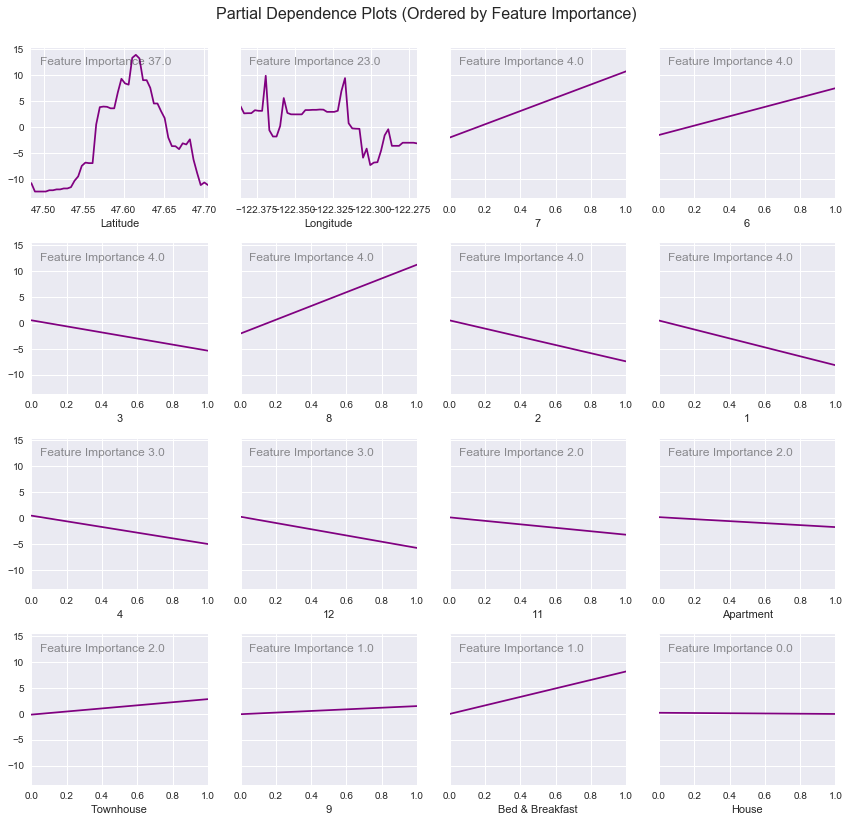

In [340]:
pred.plot_partial_dependency_plots(gdbr_monthly_model,gdbr_monthly_train_df, 4,4, 12)

In [342]:
#gdbr_monthly_pred_df.to_csv('predictions/gdbr_monthly_pred_results_random_sample.csv')
gdbr_monthly_pred_df.to_csv('predictions/gdbr_monthly_pred_results_OR50_RD10_loft_sample.csv')

## Adding additional features to monthly df

In [343]:
# Identifying columns from listing_data_df that we can add to monthly_data_df
#col_diff = 
np.setdiff1d(np.array(listing_data_df.columns),np.array(monthly_data_df.columns) )

array([u'Annual_Revenue_LTM', u'Average_Daily_Rate', u'Bathrooms',
       u'Calendar_Last_Updated', u'Cancellation_Policy', u'Checkin_Time',
       u'Checkout_Time', u'Cleaning_Fee', u'Count_Available_Days_LTM',
       u'Count_Blocked_Days_LTM', u'Count_Reservation_Days_LTM',
       u'Created_Date', 'Days_Since_Created', u'Extra_People_Fee',
       u'Instantbook_Enabled', u'Last_Scraped_Date',
       u'Listing_Main_Image_URL', u'Listing_Title', u'Listing_URL',
       u'Max_Guests', u'Minimum_Stay', u'Number_of_Bookings_LTM',
       u'Number_of_Photos', u'Number_of_Reviews', u'Occupancy_Calculated',
       u'Occupancy_Rate_LTM', u'Overall_Rating', 'Pike_Market',
       u'Published_Monthly_Rate', u'Published_Nightly_Rate',
       u'Published_Weekly_Rate', u'Response_Rate', u'Response_Time_min',
       u'Security_Deposit', u'Superhost', u'Zipcode', 'nonroom', 'parking',
       'private_bath', 'view', 'walk', 'water'], dtype=object)

In [344]:
listing_gdbr_cols_keep_merge = [
 'Property_ID',
 'Days_Since_Created',
 'Number_of_Photos',
 'Bathrooms',   
# 'Bedrooms',   # Already in monthly_df
 'Instantbook_Enabled',
# 'EDR',        # Already in monthly_df
# 'Latitude',   # Already in monthly_df
# 'Longitude',  # Already in monthly_df
 'Security_Deposit',
 'Extra_People_Fee',
 'Cleaning_Fee',
 'Superhost',
 'Overall_Rating',
 'Number_of_Reviews',
 'Pike_Market',
 'nonroom',
 'private_bath',
 'view',
 'water',
 'parking'
]

In [345]:
merge_df = pd.merge(monthly_data_df, 
                    listing_data_df[listing_gdbr_cols_keep_merge], 
                    left_on='Property_ID',  right_on='Property_ID', how='inner')

In [346]:
merge_df.shape

(7418, 39)

In [347]:
merge_df.head()

,Property_ID,Host_ID,Property_Type,Listing_Type,Bedrooms,Reporting_Month,Occupancy_Rate,Revenue,ADR,Number_of_Reservations,Reservation_Days,Available_Days,Blocked_Days,Country,State,City,Zip_code,Neighborhood,Metropolitan_Statistical_Area,Latitude,Longitude,Month,EDR,Days_Since_Created,Number_of_Photos,Bathrooms,Instantbook_Enabled,Security_Deposit,Extra_People_Fee,Cleaning_Fee,Superhost,Overall_Rating,Number_of_Reviews,Pike_Market,nonroom,private_bath,view,water,parking
0,9460,30832.0,Bed & Breakfast,Private room,1,2015-04-01,0.778,1559.0,74.24,6,21,6,3,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,4,57.75872,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
1,9460,30832.0,Bed & Breakfast,Private room,1,2016-04-01,0.733,2618.0,119.00,6,22,8,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,4,87.22700,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
2,9460,30832.0,Bed & Breakfast,Private room,1,2015-08-01,0.903,2832.0,101.14,8,28,3,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,8,91.32942,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
3,9460,30832.0,Bed & Breakfast,Private room,1,2016-08-01,0.839,3654.0,140.54,8,26,5,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,8,117.91306,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
4,9460,30832.0,Bed & Breakfast,Private room,1,2014-12-01,0.769,1540.0,77.00,6,20,6,5,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,12,59.21300,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0


In [348]:
merge_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR',            u'Days_Since_Created',
                    u'Number_of_Photos',                     u'Bathrooms',
                 u'Instan

In [349]:
merge_gdbr_cols_keep = [
# ==== LISTING DETAILS ==========
# ---- Include    
'Days_Since_Created', 'Number_of_Photos',
#'Max_Guests', 'Minimum_Stay', 
#'Bathrooms', 'Bedrooms',
'Instantbook_Enabled',
# ---- Exclude 
#'Property_ID', 'Listing_Title', 'Listing_Main_Image_URL','Listing_URL','Created_Date', 
#'Check-in_Time', 'Checkout_Time', 
    
# ==== BOOKING HISTORY =========
# ---- Include
'EDR', 
# ---- Exclude 
#'Number_of_Bookings_LTM','Occupancy_Calculated', 'Last_Scraped_Date',
#'Count_Blocked_Days_LTM', 'Count_Reservation_Days_LTM','Count_Available_Days_LTM',
#'Annual_Revenue_LTM', 'Average_Daily_Rate'
#'Calendar_Last_Updated', 

# ==== LOCATION ================
# ---- Include
'Latitude', 'Longitude',
# ---- Exclude 
#'Country', 'State','City', 'Metropolitan_Statistical_Area',    

# ==== EXTENDED STAY DETAILS ===
# ---- Include
# --- -Exclude 
#'Published_Monthly_Rate','Published_Nightly_Rate', 'Published_Weekly_Rate', 
 
# ==== ADDITIONAL FEES =========
# ---- Include
'Security_Deposit', 'Extra_People_Fee', 'Cleaning_Fee', 

# ==== HOST QUALITY ============
# ---- Include
'Superhost', 'Overall_Rating','Number_of_Reviews',  
# ---- Exclude 
#'Response_Rate', 'Response_Time_min',

# ==== SPECIAL FEATURES ========
# ---- Include
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water','parking',
# ---- Exclude 
]

In [350]:
merge_gdbr_cols_dummy =[
#'Zip_code',
#'Neighborhood',
'Month',
'Property_Type',
]

In [351]:
gdbr_merge_pred_df, gdbr_merge_train_df, gdbr_merge_model = pred.get_model_predictions_df(GradientBoostingRegressor, 
                                                                       merge_df, 'EDR', 
                                                                       merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
                                                                       loft_sample=True)

Running <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> for label EDR
(4830, 2588)
Splitting into 4830 training instances
((4830, 36), (2588, 36))
Running cross validation...
CV MSE: 310.198794077, CV R2: 0.43159495318
Training model...
Test MSE: 382.35003025, Test R2: 0.386117222335
Returned pred df with shape (2588,)


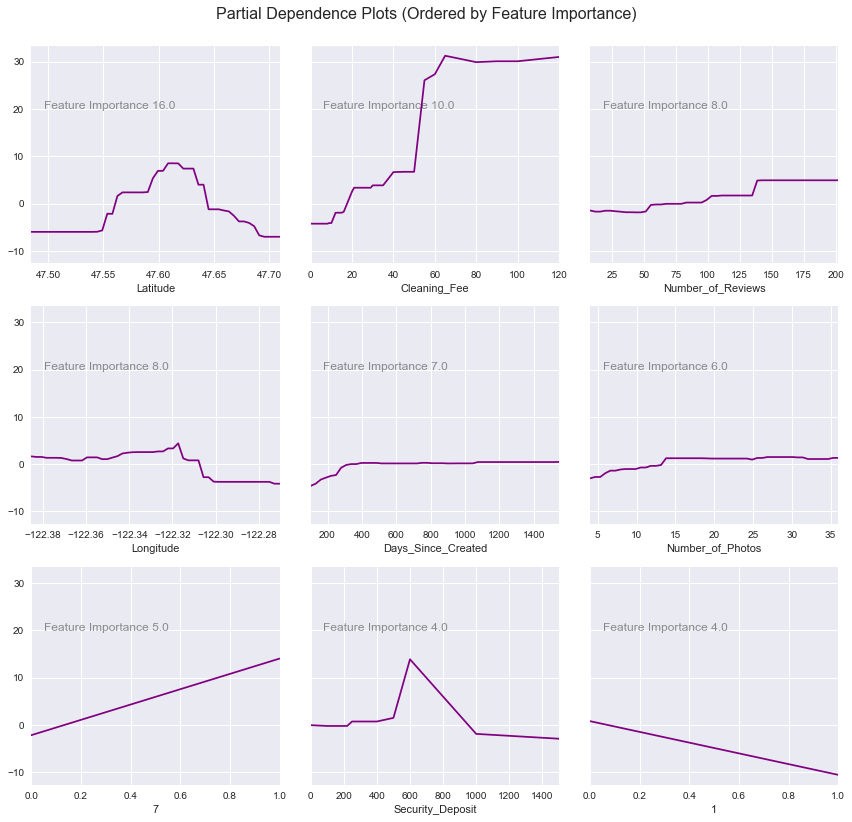

In [204]:
pred.plot_partial_dependency_plots(gdbr_merge_model,gdbr_merge_train_df)

In [154]:
gdbr_merge_pred_df.to_csv('predictions/gdbr_monthly_pred_merge_results_core_loft_sample.csv')
#gdbr_merge_pred_df.to_csv('predictions/gdbr_monthly_pred_merge_results_random_sample.csv')

In [160]:
rf_merge_pred_df, rf_merge_model  = pred.get_model_predictions_df(RandomForestRegressor, 
                                                 merge_df, 'EDR', 
                                                 merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
                                                   loft_sample=True)

Running <class 'sklearn.ensemble.forest.RandomForestRegressor'> for label EDR
(6209, 3257)
Splitting into 6209 training instances
((6209, 154), (3257, 154))
Running cross validation...
CV MSE: 439.196342678, CV R2: 0.374624300946
Training model...
Test MSE: 525.728188914, Test R2: 0.30276845483
Returned pred df with shape (3257,)


In [161]:
lr_lasso_merge_pred_df, lr_lasso_merge_model  = pred.get_model_predictions_df(Lasso, 
                                                       merge_df, 'EDR', 
                                                       merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
                                                   loft_sample=True)

Running <class 'sklearn.linear_model.coordinate_descent.Lasso'> for label EDR
(6209, 3257)
Splitting into 6209 training instances
((6209, 154), (3257, 154))
Running cross validation...
CV MSE: 444.82829754, CV R2: 0.372664202186
Training model...
Test MSE: 603.520424433, Test R2: 0.199598790891
Returned pred df with shape (3257,)


In [162]:
lr_ridge_merge_pred_df, lr_ridge_gdbr_merge_model  = pred.get_model_predictions_df(Ridge, 
                                                       merge_df, 'EDR', 
                                                       merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
                                                   loft_sample=True)

Running <class 'sklearn.linear_model.ridge.Ridge'> for label EDR
(6209, 3257)
Splitting into 6209 training instances
((6209, 154), (3257, 154))
Running cross validation...
CV MSE: 441.055493369, CV R2: 0.377186012195
Training model...
Test MSE: 475.096281324, Test R2: 0.36991753283
Returned pred df with shape (3257,)


### Conclusion: For predictive accuracy, Gradient Boosting consistently outperforms all other  models. 

### Stratifying samples by Zipcode

In [114]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=0)

# for train_index, test_index in sss.split(gdbr_df,
#                                          gdbr_df['Zipcode']):
#     #print("TRAIN:", train_index, "TEST:", test_index)    
#     X_train = X.iloc[train_index]
#     X_test = X.iloc[test_index]
#     y_train = y.iloc[train_index]
#     y_test = y.iloc[test_index]

# print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
#listing_df.shape

In [ ]:
# #for neighborhood in listing_df.Neighborhood:
# def get_stratefied_samples(df, column, frac=0.7):
#     train_ind = []
#     test_ind = []
#     for neighborhood in listing_df.Neighborhood.unique():
#         nhood_ind = listing_df[listing_df.Neighborhood==neighborhood].index.values
#         nhood_train = np.random.choice(nhood_ind,  replace=False, size=len(nhood_ind)*frac)
#         nhood_test = np.setdiff1d(nhood_ind,nhood_train)
#         #nhood_ind.shape, nhood_train.shape, nhood_test.shape
#         for i in nhood_train:
#             train_ind.append(i)
#         for i in nhood_test:
#             test_ind.append(i)
#     return (train_ind), (test_ind)

In [ ]:
# train_ind, test_ind = get_stratefied_samples(listing_df, 'Neighborhood')

In [ ]:
# np.intersect1d(np.array(train_ind), np.array(test_ind)), len(train_ind), len(test_ind)

In [ ]:
# X_train = listings_gdbr_df.loc[train_ind].values
# X_test = listings_gdbr_df.loc[test_ind].values

# y_train = listing_df.loc[train_ind]['EDR'].values
# y_test = listing_df.loc[test_ind]['EDR'].values

In [ ]:
# -get_cv_score(GradientBoostingRegressor(), X_train, y_train, cv=5, scoring='neg_mean_squared_error'), \
# get_cv_score(GradientBoostingRegressor(), X_train, y_train, cv=5, scoring='r2')

In [ ]:
# gdbr = GradientBoostingRegressor()
# gdbr.fit(X_train, y_train)
# y_pred = gdbr.predict(X_test)
# mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# Statistical Inference

In [ ]:
cols_corr_matrix = [
#'Property_ID', 'Host_ID', 'Property_Type', 'Listing_Type', 
'Bedrooms', 'Bathrooms',
#'Reporting_Month', 
'Occupancy_Rate', 'Revenue', 'ADR','EDR', 
'Number_of_Reservations', 'Reservation_Days', 'Available_Days', 'Blocked_Days',
#'Country', 'State', 'City', 'Zip_code', 'Neighborhood',
#'Metropolitan_Statistical_Area', 
'Latitude', 'Longitude', 'Month',
'Days_Since_Created', 'Number_of_Photos', 
'Security_Deposit', 'Extra_People_Fee','Cleaning_Fee',
'Superhost', 'Overall_Rating', 'Number_of_Reviews', 'Instantbook_Enabled', 
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water'
]

In [ ]:
eda.plot_corr_matrix_heatmap(merge_df[cols_corr_matrix], annot=False)

In [ ]:
merge_df.columns

In [ ]:
X = merge_df[['Number_of_Reviews', 'Instantbook_Enabled','private_bath' ]]
y = merge_df.EDR
X = sm.add_constant(X)
sm_lr_Number_of_Reviews = sm.OLS(y,X).fit()
pred.get_linreg_summary_sm(sm_lr_Number_of_Reviews)

## Using NLP to find additional features

Let's conduct some text analysis to compare the top and bottom properties based on expected daily rates to see if we can find any interesting word trends.  

Perhaps higher EDR properties have unique features that are absent in low EDR properties? 

In [ ]:
listing_data_df.sort_values(by='EDR', ascending=False)[:5]

In [ ]:
listing_data_df.sort_values(by='EDR', ascending=False)[-5:]

In [ ]:
limit = 50
listings_titles = listing_data_df[['Listing_Title', 'EDR']].sort_values(by='EDR', 
                                                                                         ascending=False)['Listing_Title']

listings_titles_tf = CountVectorizer(stop_words='english')
listings_titles_tf_matrix = listings_titles_tf.fit_transform(listings_titles)

listings_titles_tf_vocab = np.array(listings_titles_tf.get_feature_names())

listings_titles_top_tf = listings_titles_tf_matrix.toarray()[:limit]
listings_titles_bot_tf = listings_titles_tf_matrix.toarray()[-limit:]

listings_titles_top_tf_sum = np.sum(listings_titles_top_tf, axis=0)
listings_titles_bot_tf_sum = np.sum(listings_titles_bot_tf, axis=0)


listings_titles_tfidf = TfidfVectorizer(stop_words='english')
listings_titles_tfidf_matrix = listings_titles_tfidf.fit_transform(listings_titles)


listings_titles_top_tfidf = listings_titles_tfidf_matrix.toarray()[:limit]
listings_titles_bot_tfidf = listings_titles_tfidf_matrix.toarray()[-limit:]

listings_titles_top_tfidf_sum = np.sum(listings_titles_top_tfidf, axis=0)
listings_titles_bot_tfidf_sum = np.sum(listings_titles_bot_tfidf, axis=0)
listings_titles_top_tfidf_cnt = np.count_nonzero(listings_titles_top_tfidf, axis=0)
listings_titles_bot_tfidf_cnt = np.count_nonzero(listings_titles_bot_tfidf, axis=0)

listings_titles_top_tfidf_mean = listings_titles_top_tfidf_sum/listings_titles_top_tfidf_cnt
listings_titles_bot_tfidf_mean = listings_titles_bot_tfidf_sum/listings_titles_bot_tfidf_cnt

listings_titles_top_tfidf_sorted_ind = np.argsort(listings_titles_top_tfidf_mean)[::-1]
listings_titles_bot_tfidf_sorted_ind = np.argsort(listings_titles_bot_tfidf_mean)[::-1]

listings_titles_top_tfidf_top10words = listings_titles_tf_vocab[listings_titles_top_tfidf_sorted_ind[:10]]
listings_titles_bot_tfidf_top10words = listings_titles_tf_vocab[listings_titles_bot_tfidf_sorted_ind[:10]]

listings_titles_top_tfidf_top10wordcounts = listings_titles_top_tf_sum[listings_titles_top_tfidf_sorted_ind[:10]]
listings_titles_bot_tfidf_top10wordcounts = listings_titles_bot_tf_sum[listings_titles_bot_tfidf_sorted_ind[:10]]

print ("Highest tfidf words for top priced properties:")
print ("------------------------------")
for word, count in zip(listings_titles_top_tfidf_top10words, listings_titles_top_tfidf_top10wordcounts):
    print (word, count)
    
print ("Highest tfidf words for bottom priced properties:")
print ("------------------------------")
for word, count in zip(listings_titles_bot_tfidf_top10words, listings_titles_bot_tfidf_top10wordcounts):
    print (word, count)

In [ ]:
top_listings_titles = listing_data_df.sort_values(by='EDR', ascending=False)[:50]['Listing_Title']
top_listings_titles_tf = CountVectorizer(stop_words='english')
top_listings_titles_tf_matrix = top_listings_titles_tf.fit_transform(top_listings_titles)
top_listings_titles_vocab = np.array(top_listings_titles_tf.get_feature_names())
top_listings_titles_tf_sum = np.sum(top_listings_titles_tf_matrix.toarray(), axis=0)
top_listings_titles_tf_sorted_ind = np.argsort(top_listings_titles_tf_sum)[::-1]
top_listings_titles_tf_top10words = top_listings_titles_vocab[top_listings_titles_tf_sorted_ind[:10]]
top_listings_titles_tf_top10words_count = top_listings_titles_tf_sum[top_listings_titles_tf_sorted_ind[:10]]
print ("Most frequency occuring words:")
print ("------------------------------")
for word, count in zip(top_listings_titles_tf_top10words, top_listings_titles_tf_top10words_count):
    print (word, count)

In [ ]:
bot_listings_titles = listing_data_df.sort_values(by='EDR', ascending=False)[-50:]['Listing_Title']
bot_listings_titles_tf = CountVectorizer(stop_words='english')
bot_listings_titles_tf_matrix = bot_listings_titles_tf.fit_transform(bot_listings_titles)
bot_listings_titles_vocab = np.array(bot_listings_titles_tf.get_feature_names())
bot_listings_titles_tf_sum = np.sum(bot_listings_titles_tf_matrix.toarray(), axis=0)
bot_listings_titles_tf_sorted_ind = np.argsort(bot_listings_titles_tf_sum)[::-1]
bot_listings_titles_tf_top10words = bot_listings_titles_vocab[bot_listings_titles_tf_sorted_ind[:10]]
bot_listings_titles_tf_top10words_count = bot_listings_titles_tf_sum[bot_listings_titles_tf_sorted_ind[:10]]
print ("Most frequency occuring words:")
print ("------------------------------")
for word, count in zip(bot_listings_titles_tf_top10words, bot_listings_titles_tf_top10words_count):
    print (word, count)

What words occur in the top listings (by EDR) that don't occur in the other listings?

In [ ]:
top_listing_unique = np.setdiff1d(top_listings_titles_vocab,bot_listings_titles_vocab)
top_listing_unique

In [ ]:
ind = []
for word in top_listing_unique:
    ind.append(np.where(top_listings_titles_vocab==word)[0][0])

In [ ]:
top_listing_unique_word_counts=[]
for word, count in zip(top_listing_unique,top_listings_titles_tf_sum[ind]):
    top_listing_unique_word_counts.append((word, count))

In [ ]:
top_listing_unique_word_counts

Let's look at the calendar data from Airbnb

In [ ]:
cal_df = pd.read_csv('data/calendar.csv')

In [ ]:
cal_df.columns

In [ ]:
cal_df['available'] = cal_df['available'].replace({'t':1, 'f':0})
cal_df['price'] = cal_df['price'].str.replace('$','').str.replace(',', '').astype(float)

In [ ]:
cal_df_id = cal_df.listing_id.unique()

In [ ]:
loft_df_id = listings_pred_df.Property_ID.unique()

In [ ]:
np.intersect1d(cal_df_id, loft_df_id).shape

In [ ]:
listings_check_df = listing_data_df[['Property_ID', 
                                      'Count_Reservation_Days_LTM', 
                                      'Count_Available_Days_LTM',
                                      'Count_Blocked_Days_LTM',
                                      'Average_Daily_Rate']].sort_values(by='Count_Reservation_Days_LTM', ascending=False)

In [ ]:
cal_agg_df = cal_df.groupby('listing_id').agg({'price':np.mean, 'available':np.sum, 'date':len})

In [ ]:
cal_agg_df.head()

In [ ]:
cal_agg_df.columns=['Count_Available_Days', 'Average_Price', 'Count_Total_Days']

In [ ]:
listings_check_df.set_index('Property_ID', inplace=True)

In [ ]:
listings_check_df.head()

In [ ]:
listings_check_df.drop(13321038, inplace=True)
listings_check_df.drop(11491756, inplace=True)
listings_check_df.drop(6852288, inplace=True)
listings_check_df.drop(9772201, inplace=True)

In [ ]:
cal_agg_df.head()

In [ ]:
cal_agg_df.shape, listings_check_df.shape

In [ ]:
np.intersect1d(cal_agg_df.index, listings_check_df.index).shape

In [ ]:
compare_df = pd.concat([cal_agg_df,listings_check_df], axis=1, join='inner')

In [ ]:
compare_df.columns.values

In [ ]:
compare_df = compare_df[['Average_Price','Average_Daily_Rate',
                         'Count_Available_Days','Count_Reservation_Days_LTM',
                         'Count_Total_Days', 'Count_Available_Days_LTM','Count_Blocked_Days_LTM']]

In [ ]:
compare_df